In [1]:
import imgaug as ia
# imgaug uses matplotlib backend for displaying images
%matplotlib inline
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
from imgaug import augmenters as iaa 
# imageio library will be used for image input/output
import imageio
import numpy as np
from tqdm import trange
import cv2
import os
import glob
import imgaug as ia
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
from imgaug import augmenters as iaa 
import matplotlib.pyplot as plt
import xmltodict
# this library is needed to read XML files for converting it into CSV
import dicttoxml
from xml.dom.minidom import parseString

classes = ['aeroplane', 'bicycle', 'bird','boat','bottle', 'bus', 'car',
           'cat', 'chair', 'cow','diningtable','dog', 'horse', 'motorbike',
           'person','pottedplant','sheep', 'sofa', 'train', 'tvmonitor']

def remove_duplicate(s):
    '''
    I created this function b/c i am looping over all the keys in the xml file
    and in case if xmldict have only one object the loop sitll consider the 
    <part> keys to be part of object so i am just looping over same object again 
    and again. So i just rmove those duplication with this
    '''
    x = s.split(' ')
    y = list(set(x))
    y = ' '.join(map(str, y))
    return y

In [2]:
# Define the directories in which data is and where to put the augumented data
# tht input directory should contain both image files and also the xml files
# the augumented images and xml files with be saved in op dir's.

img_path = glob.glob(os.path.join('D:/GIT_HUB/DATA_aug_detection/data/*.jpg'))
xml_path = glob.glob(os.path.join('D:/GIT_HUB/DATA_aug_detection/data//*.xml'))

op_img_path = 'D:/GIT_HUB/DATA_aug_detection/aug_data/'
op_xml_path = 'D:/GIT_HUB/DATA_aug_detection/aug_data/'

In [13]:
# for now let's select only one iamge and one xml file from above lists

img = cv2.imread(img_path[-1])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
filepath = xml_path[-1]

full_dict = xmltodict.parse(open( filepath , 'rb' ))

In [14]:
# Extracting the coords and class names from xml file
names = []
coords = []

obj_boxnnames = full_dict[ 'annotation' ][ 'object' ] # names and boxes
file_name = full_dict[ 'annotation' ][ 'filename' ]#full_dict[ 'annotation' ][ 'filename' ]

for i in range(len(obj_boxnnames)):
    # 1st get the name and indices of the class
    try:
        obj_name = obj_boxnnames[i]['name']
    except KeyError:
        obj_name = obj_boxnnames['name']  # if the xml file has only one object key
        
    obj_ind = [i for i in range(len(classes)) if obj_name == classes[i]] # get the index of the class
    obj_ind = int(np.array(obj_ind))
    # 2nd get tht bbox coord and append the class name at the end
    try:
        obj_box = obj_boxnnames[i]['bndbox']
    except KeyError:
        obj_box = obj_boxnnames['bndbox'] # if the xml file has only one object key
    bounding_box = [0.0] * 4                    # creat empty list
    bounding_box[0] = int(float(obj_box['xmin']))# two times conversion is for handeling exceptions 
    bounding_box[1] = int(float(obj_box['ymin']))# so that if coordinates are given in float it'll
    bounding_box[2] = int(float(obj_box['xmax']))# still convert them to int
    bounding_box[3] = int(float(obj_box['ymax']))
    bounding_box.append(obj_ind) 
    bounding_box = str(bounding_box)[1:-1]      # remove square brackets
    bounding_box = "".join(bounding_box.split())
    names.append(obj_name)
    coords.append(bounding_box)
    
# this for removing duplicate coordinates and converting the appended list into array
# such that the 1st row of array containg the coords. as [xmin, ymin, xmax, ymax, class_index] and
# the second row contains the second bbox coords

coords = ' '.join(map(str, coords))# convert list to string
coords = remove_duplicate(coords)
coords = coords.split(' ')
t = []
for i in range(len(coords)):
    t.append(coords[i].split(','))
t = np.array(t).astype(np.uint32)
# seperate the class indexes and 4 coords.
coords = t[:,0:4]
class_idx = t[:,-1]
# convert class index to class names/labels
class_det = np.take(classes, class_idx)

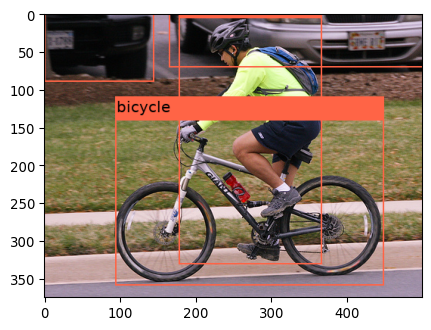

In [15]:
# now give the extracted bbox coords to the imageaug library for augumentation
bbs = BoundingBoxesOnImage.from_xyxy_array(coords, shape=img.shape)
for i in range(len(bbs)):
    bbs[i].label = class_det[i]
# this line will plot the original input image
ia.imshow(bbs.draw_on_image(img, color=[255, 100, 70], size=2))
# you can change these options and there parameters to get different augmented outputs

seq = iaa.Sequential([
    # these are essential augumentations
    iaa.Fliplr(0.3),
    iaa.Flipud(0.3),
    # these are less important means only a few of the following will be applied
    
    iaa.SomeOf((0, 5), [
        
    iaa.GammaContrast(1.5),
    iaa.Affine(translate_percent={"x": (-0.3, 0.3), "y": (-0.3, 0.3)}, scale=(0.5, 0.9)),
    iaa.Affine(rotate=(-60, 60)),
    iaa.Multiply((0.5, 1.5)),
    iaa.AdditiveGaussianNoise(scale=(10, 60)),
    iaa.GaussianBlur(sigma=(0, 0.5))
    ],random_order=True),
    
    ], random_order=True)

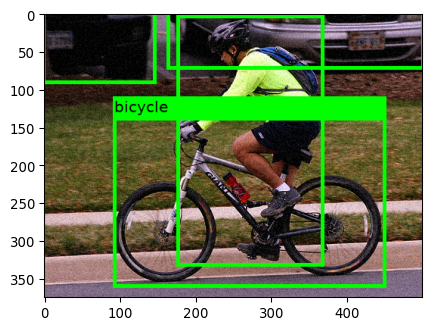

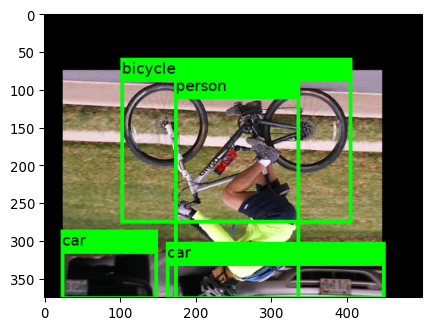

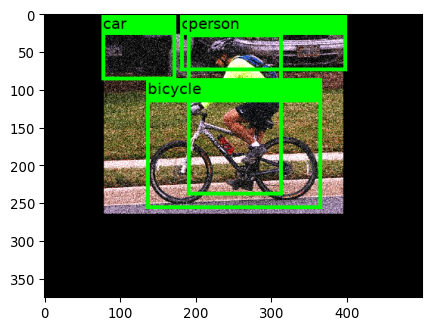

In [16]:
# different runs of the above function will give differnt outputs
for i in range(3):
    image_aug, bbs_aug = seq.augment(image=img, bounding_boxes=bbs)
    #   disregard bounding boxes which have fallen out of image pane   
    bbs_aug = bbs_aug.remove_out_of_image()
    #   clip bounding boxes which are partially outside of image pane
    bbs_aug = bbs_aug.clip_out_of_image()

    ia.imshow(bbs_aug.draw_on_image(image_aug, size=5))

In [35]:
'''
Now updata the dictionary wiht new augmented values
'''

#full_dict = xmltodict.parse(open( filepath , 'rb' ))

obj_boxnnames = full_dict[ 'annotation' ][ 'object' ] # names and boxes

for i in range(len(bbs_aug)):
    # 1st get the name and indices of the class
    try:
        obj_boxnnames[i]['name'] = str(bbs_aug[i].label)
    except KeyError:
        obj_boxnnames['name']   = str(bbs_aug[i].label)# if the xml file has only one object key
    obj_ind = [i for i in range(len(classes)) if obj_name == classes[i]] # get the index of the object
    obj_ind = int(np.array(obj_ind))
    # 2nd get tht bbox coord and append the class name at the end
    try:
        obj_boxnnames[i]['bndbox']['xmin'] = str(int(bbs_aug[i][0][0]))
        obj_boxnnames[i]['bndbox']['ymin'] = str(int(bbs_aug[i][0][1]))
        obj_boxnnames[i]['bndbox']['xmax'] = str(int(bbs_aug[0][1][0]))
        obj_boxnnames[i]['bndbox']['ymax'] = str(int(bbs_aug[0][1][1]))
    except KeyError:
        obj_boxnnames['bndbox']['xmin'] = str(int(bbs_aug[i][0][0]))
        obj_boxnnames['bndbox']['ymin'] = str(int(bbs_aug[i][0][1]))
        obj_boxnnames['bndbox']['xmax'] = str(int(bbs_aug[0][1][0]))
        obj_boxnnames['bndbox']['ymax'] = str(int(bbs_aug[0][1][1]))

In [36]:
'''
Now write the new augmented xml file and image
'''
# dictionary to xml
xml = dicttoxml.dicttoxml(full_dict, attr_type=False) # set attr_type to False to not wite type of each entry
# xml bytes to string
xml = xml.decode() 
# parsing string
dom = parseString(xml)
# pritify the string
dom = dom.toprettyxml()
# remove the additional root added by the library
dom = dom.replace('<root>','')
dom = dom.replace('</root>','')
# write the pretified string
xmlfile = open(op_img_path + "aug_{}.xml".format(file_name[:-4]), "w") 
xmlfile.write(dom) 
xmlfile.close() 
# wirte image
imageio.imwrite(op_img_path + 'aug_{}'.format(file_name), image_aug)
